# Task 1: EDA #

In [1]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
from collections import Counter

# Load data
recipes = pd.read_csv("/Users/seonminhwang/Downloads/archive/RAW_recipes.csv")
interactions = pd.read_csv("/Users/seonminhwang/Downloads/archive/RAW_interactions.csv")

# Ensure 'ingredients' column is properly parsed (if stored as a string list)
recipes['ingredients'] = recipes['ingredients'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Add a column for the number of ingredients per recipe
recipes['num_ingredients'] = recipes['ingredients'].apply(len)

In [2]:
# Summarize the datasets
eda_summary = {
    "Total Recipes": len(recipes),
    "Total Interactions": len(interactions),
    "Average Ingredients Per Recipe": recipes["num_ingredients"].mean(),
    "Median Ingredients Per Recipe": recipes["num_ingredients"].median(),
    "Earliest Submission Date": recipes["submitted"].min(),
    "Latest Submission Date": recipes["submitted"].max(),
}

In [3]:
# Extract the distribution of ratings
rating_distribution = interactions["rating"].value_counts().sort_index()

# Extract the most common ingredients
ingredient_list = recipes["ingredients"].explode()
common_ingredients = Counter(ingredient_list).most_common(10)
common_ingredients_df = pd.DataFrame(common_ingredients, columns=["Ingredient", "Count"])

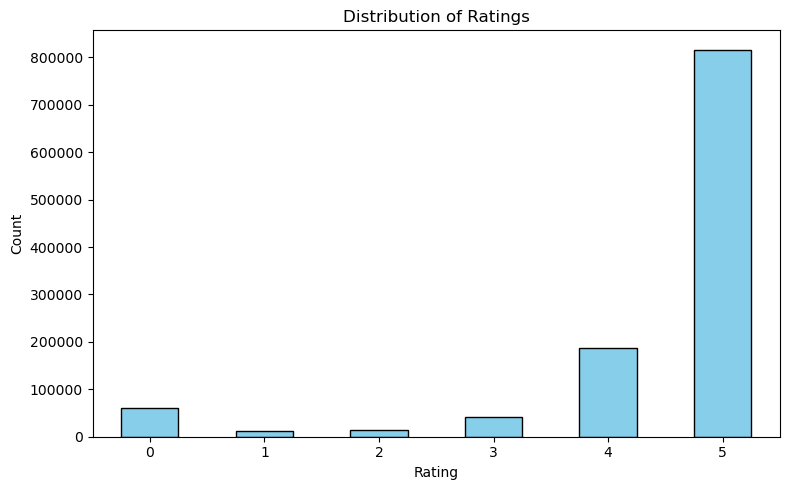

In [4]:
# Visualization: Ratings distribution
plt.figure(figsize=(8, 5))
rating_distribution.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

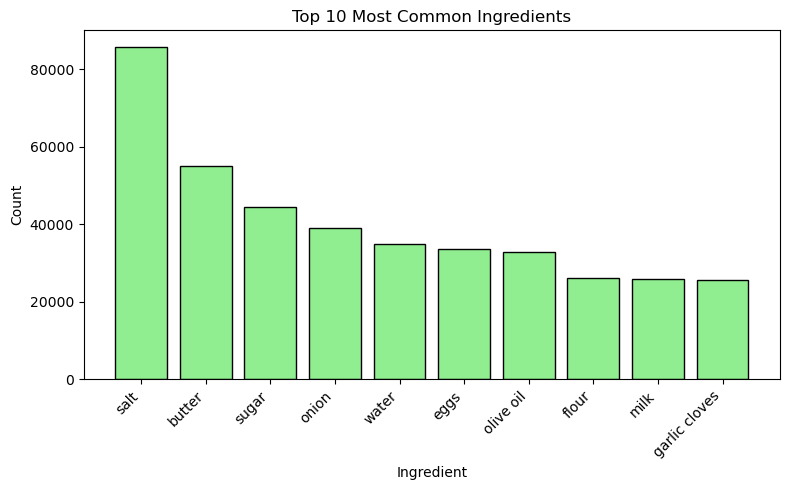

In [5]:
# Visualization: Most common ingredients
plt.figure(figsize=(8, 5))
plt.bar(common_ingredients_df["Ingredient"], common_ingredients_df["Count"], color="lightgreen", edgecolor="black")
plt.title("Top 10 Most Common Ingredients")
plt.xlabel("Ingredient")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

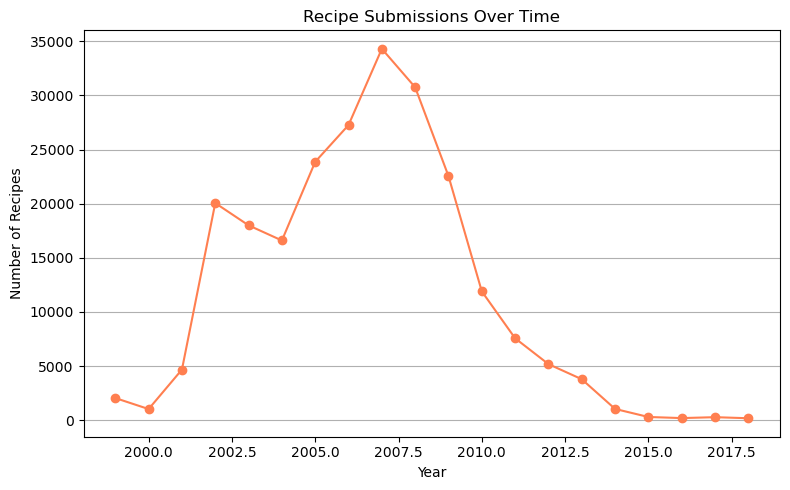

In [6]:
# Visualization: Recipe submissions over time
recipes["submitted"] = pd.to_datetime(recipes["submitted"])
submission_trend = recipes["submitted"].dt.year.value_counts().sort_index()
plt.figure(figsize=(8, 5))
submission_trend.plot(kind="line", marker="o", color="coral")
plt.title("Recipe Submissions Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Recipes")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [7]:
# Create a DataFrame for EDA summary
eda_summary_df = pd.DataFrame(eda_summary.items(), columns=["Metric", "Value"])
print("\nExploratory Data Analysis Summary:")
print(eda_summary_df)

# Extract the distribution of ratings
rating_distribution = interactions["rating"].value_counts().sort_index()

# Extract the most common ingredients
ingredient_list = recipes["ingredients"].explode()
common_ingredients = Counter(ingredient_list).most_common(10)
common_ingredients_df = pd.DataFrame(common_ingredients, columns=["Ingredient", "Count"])

# Print the top 10 most common ingredients
print("\nTop 10 Most Common Ingredients:")
print(common_ingredients_df)


Exploratory Data Analysis Summary:
                           Metric       Value
0                   Total Recipes      231637
1              Total Interactions     1132367
2  Average Ingredients Per Recipe    9.051153
3   Median Ingredients Per Recipe         9.0
4        Earliest Submission Date  1999-08-06
5          Latest Submission Date  2018-12-04

Top 10 Most Common Ingredients:
      Ingredient  Count
0           salt  85746
1         butter  54975
2          sugar  44535
3          onion  39065
4          water  34914
5           eggs  33761
6      olive oil  32822
7          flour  26266
8           milk  25786
9  garlic cloves  25748


# Task 2: Identify Motif for Predictive Task #

In [8]:
# Create a mapping of recipe IDs to their ingredient sets
recipe_ingredient_sets = recipes.set_index("id")["ingredients"].apply(set)

In [9]:
# Define a function to compute Jaccard similarity
def jaccard_similarity(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union != 0 else 0

In [10]:
# Recommend recipes based on Jaccard similarity
def recommend_recipes(target_recipe_id, recipes, recipe_ingredient_sets, num_recommendations=5):
    target_ingredients = recipe_ingredient_sets[target_recipe_id]
    similarities = {}
    
    for recipe_id, ingredients in recipe_ingredient_sets.items():
        if recipe_id != target_recipe_id:  # Skip the target recipe itself
            similarity = jaccard_similarity(target_ingredients, ingredients)
            similarities[recipe_id] = similarity

    # Sort recipes by similarity and get top recommendations
    top_recommendations = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:num_recommendations]

    # Fetch recipe details
    recommended_recipes = recipes.loc[recipes["id"].isin([rec[0] for rec in top_recommendations])].copy()
    recommended_recipes["Jaccard Similarity"] = [rec[1] for rec in top_recommendations]
    
    # Display results
    print(f"\nTop {num_recommendations} Recipes Similar to '{recipes.loc[recipes['id'] == target_recipe_id, 'name'].values[0]}':\n")
    for _, row in recommended_recipes.iterrows():
        print(f"Recipe: {row['name']} (ID: {row['id']})")
        print(f"Ingredients: {', '.join(row['ingredients'])}")
        print(f"Jaccard Similarity: {row['Jaccard Similarity']:.2f}\n")
    
    return recommended_recipes

In [11]:
# Example: Recommend recipes similar to recipe_id=137739
recommendations = recommend_recipes(137739, recipes, recipe_ingredient_sets, num_recommendations=5)


Top 5 Recipes Similar to 'arriba   baked winter squash mexican style':

Recipe: berber spice roasted chickpeas (ID: 514675)
Ingredients: dried garbanzo beans, salt, olive oil, mixed spice
Jaccard Similarity: 0.38

Recipe: ed s homemade microwave buttery popcorn (ID: 408958)
Ingredients: popcorn, butter, olive oil, salt
Jaccard Similarity: 0.38

Recipe: honey roasted peanuts (ID: 147856)
Ingredients: peanuts, butter, honey, salt
Jaccard Similarity: 0.38

Recipe: julia child method of preparing garlic (ID: 104441)
Ingredients: garlic, butter, olive oil, salt
Jaccard Similarity: 0.38

Recipe: potatoes rissole (ID: 72347)
Ingredients: russet potatoes, salt, butter, olive oil
Jaccard Similarity: 0.38



# Task 3: Machine Learning Modeling #

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Compute Jaccard similarity for all user-recipe pairs
def compute_jaccard_similarity(row, recipe_ingredient_sets, user_profiles):
    user_profile = user_profiles[row["user_id"]]
    recipe_ingredients = recipe_ingredient_sets[row["recipe_id"]]
    return len(user_profile & recipe_ingredients) / len(user_profile | recipe_ingredients) if len(user_profile | recipe_ingredients) > 0 else 0

# Create user profiles (union of all ingredients from recipes they interacted with)
recipe_ingredient_sets = recipes.set_index("id")["ingredients"].apply(set)
user_profiles = interactions.groupby("user_id")["recipe_id"].apply(
    lambda recipe_ids: set.union(*(recipe_ingredient_sets[r] for r in recipe_ids if r in recipe_ingredient_sets))
)

interactions["jaccard_similarity"] = interactions.apply(
    lambda row: compute_jaccard_similarity(row, recipe_ingredient_sets, user_profiles), axis=1
)

In [13]:
# Add user and recipe features
recipes["avg_rating"] = interactions.groupby("recipe_id")["rating"].transform("mean")
recipes["num_reviews"] = interactions.groupby("recipe_id")["rating"].transform("count")
recipes["num_ingredients"] = recipes["ingredients"].apply(len)

user_features = interactions.groupby("user_id").agg(
    user_avg_rating=("rating", "mean"),
    user_total_interactions=("recipe_id", "count")
).reset_index()

data = interactions.merge(recipes, left_on="recipe_id", right_on="id", how="left")
data = data.merge(user_features, on="user_id", how="left")

In [14]:
# Prepare data for modeling
# Target variable: High rating (1 if rating >= 4, else 0)
data["high_rating"] = (data["rating"] >= 4).astype(int)

# Features
features = [
    "jaccard_similarity", 
    "num_ingredients", 
    "avg_rating", 
    "num_reviews", 
    "user_avg_rating", 
    "user_total_interactions"
]
target = "high_rating"

X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [15]:
# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Evaluation Metrics:
Accuracy: 0.92
Precision: 0.93
Recall: 0.98
F1 Score: 0.96


In [16]:
# Feature importance
feature_importance = pd.DataFrame({
    "Feature": features,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)
print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
                   Feature  Importance
4          user_avg_rating    0.478854
0       jaccard_similarity    0.142979
3              num_reviews    0.122781
2               avg_rating    0.119761
5  user_total_interactions    0.082831
1          num_ingredients    0.052793
